In this notebook I'm going to analyse the tweet collected and the the most used hashtags by congolese on twitter
For now a simple defintion of a congolese on social media is someone who tweet using the following hashtags : DRC, RDC, RDCongo, DRCongo.

In [1]:
import sys
from collections import Counter, defaultdict
import json

Let analyse a tweet and get the hashtags involed in the tweet

In [2]:
def get_hashtags(tweet):
    entities = tweet.get('entities', {})
    hashtags = entities.get('hashtags', [])
    return [ get_text(tag) for tag in hashtags if get_text(tag) not in ['rdc', 'drc', 'rdcongo', 'drcongo']]

In [3]:
def get_text(tag):
    return tag.get('text').lower()

In [4]:
with open('../data/stream_DRC_RDC_DRCongo_RDCongo.jsonl' , 'r') as f :
    hastags = Counter()
    for line in f:
        tweet = json.loads(line)
        hashtags_in_tweet = get_hashtags(tweet)
        hastags.update(hashtags_in_tweet)
    for tag,count in hastags.most_common(25):
        print("{} : {}".format(tag, count))

ebola : 10
tchad : 4
afrique : 4
francafrique : 4
togo : 4
algerie : 4
mali : 4
faso : 4
benin : 4
cotedivoire : 4
guinee : 4
lualaba : 3
niger : 3
butembo : 3
maï_ndombe : 3
msf : 3
rtnc : 2
zerohunger : 2
ilovecongo : 2
who : 2
cholera : 2
femalepolice : 1
ethérosnational : 1
udps : 1
amanigold : 1


let check how our people uses others hastags apart from the one I selected 

In [5]:
with open('../data/stream_DRC_RDC_DRCongo_RDCongo.jsonl' , 'r') as f :
    hashtag_count = defaultdict(int)
    for line in f :
        tweet = json.loads(line)
        hashtags_in_tweet = get_hashtags(tweet)
        n_of_hashtags = len(hashtags_in_tweet)
        hashtag_count[n_of_hashtags] +=1
        tweet_with_hashtags = sum([count for n_of_tags , count in hashtag_count.items() if n_of_tags>0])
        tweet_without_hashtags = hashtag_count[0]
        total_tweet = tweet_with_hashtags + tweet_without_hashtags
print("{} tweets without hashtags  ({}%)".format(tweet_without_hashtags,  tweet_without_hashtags*100/total_tweet)) 
print("{} tweets with at least one hashtag  ({}%)".format(tweet_with_hashtags,  tweet_with_hashtags*100/total_tweet))        

146 tweets without hashtags  (75.25773195876289%)
48 tweets with at least one hashtag  (24.742268041237114%)


Conclusion we can see that we have only 92 tweets without hashtags 

### II. Tweet text analysis

In this portion of the notebook we will analyse a tweet as text and perform some NLP tasks on it such tokenization, etc

In [6]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

In [7]:
def process_text(text, tokenizer= TweetTokenizer(), words_to_remove=[]):
    """
    Process the text of a tweet
    - lowertext
    - stop world 
    - digit removal
    and return a list of strings
    """
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return [token for token in tokens if token not in words_to_remove and not token.isdigit()]
    

let do the analysis now

In [8]:
tweet_tokenizer = TweetTokenizer()
punctuation  = list(string.punctuation)
stop_word_list_english = stopwords.words('english')
stop_word_list_french = stopwords.words('french')
others_words = ['rt', 'via', '...', '…', '»:', '«:' , '’:', 'les']
words_to_remove = punctuation + stop_word_list_english + stop_word_list_french + others_words

In [9]:
term_counts = Counter()
with open('../data/stream_DRC_RDC_DRCongo_RDCongo.jsonl' , 'r') as f :
    for line in f:
        tweet = json.loads(line)
        tokens = process_text(text=tweet.get('text'), tokenizer=tweet_tokenizer, words_to_remove=words_to_remove)
        term_counts.update(tokens)
    for tag, count in term_counts.most_common(20):
        print("{}: {}".format(tag, count))

’: 70
rdc: 55
#rdc: 44
tshisekedi: 19
#drc: 15
obsèques: 12
new: 11
comme: 10
tous: 10
#ebola: 10
plus: 10
udps: 9
c'est: 9
cases: 9
congolais: 8
@nissybtk: 8
salut: 8
cette: 8
année: 8
pars: 8


We can see that we need to update our list of stop words and punctuations world like '»:', '»:' , '’:' should be removed

For now we can remove them manually , and next time we will find a way to deal wit those kind of puctuation as weel as contractions

#### III. Term frequency

*The following graph will plot the term frequency of words vs his position within the ranking term*

In [10]:
y = [count for tag, count in term_counts.most_common(100)]
x = range(1, len(y)+1)

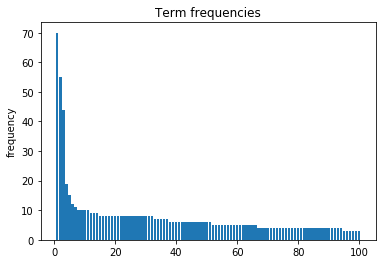

In [11]:
plt.bar(x, y)
plt.title("Term frequencies")
plt.ylabel('frequency')
plt.savefig('../images/term_distribution.png')

How can we explain this figure?
The figure shows a long tail, it can be explain with the fact the a small pottion of frequent item dominate the distribution, and . there is a large number of item with low frequency. This can also be explained as the **80-20** rule.

### III. Time series analysis 

Basically in this  section we will use the field `created_at` of a tweet and answer to this question:
**at what time congolese use twitter the most?**, the answer to this question can be usefull when we want to know when to tweet to reach a maximum audiance.

In [12]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import pickle
from datetime import datetime

In [26]:
def read_tweets_file(path):
    """
    a genrator function which read a json file of tweets and return a iterator of this content file by line
    param:
    path : json file path
    """
    with open(path, 'r') as f :
        for line in f:
            tweet = json.loads(line)
            yield tweet

In [27]:
all_dates = list()
for tweet in read_tweets_file('../data/stream_DRC_RDC_DRCongo_RDCongo.jsonl'):
    all_dates.append(tweet.get('created_at'))
idx = pd.DatetimeIndex(all_dates)
ones = np.ones(len(idx))
one_second_series = pd.Series(ones, index=idx)

Downsample the series into 1 minute bins and sum the values of the timestamps falling into a bin.
Basically this helps us to know how many tweet we have in one minute time slot.

In [15]:
per_minute = one_second_series.resample('1Min').apply(sum).fillna(0)

/Users/espoir-mur/Projects/Personnal/twitter-analysis/.venv3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


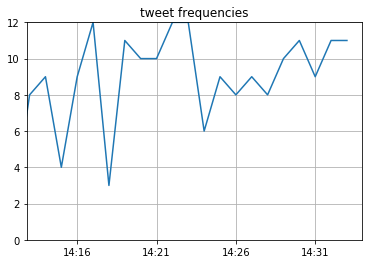

In [16]:
fig, ax=plt.subplots()
ax.grid(True)
ax.set_title('tweet frequencies')
hours = mdates.MinuteLocator(interval=5)
date_formatter = mdates.DateFormatter('%H:%M')
max_date = idx.max()
min_date = idx.min()
max_freq = per_minute.max()
ax.set_ylim(0,  max_freq)
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(date_formatter)
ax.set_xlim(min_date, max_date)
ax.plot(per_minute.index, per_minute)
plt.savefig('../images/tweet_per_time.png')

We can see from the figure that our tweet were collected from a 30 minutes time intervales (18:00-18:30) and we have the pick time at 18:19 with more that 14 tweets.
Since our time slot was too small we can't find when congolese tweet a lot , but the procedure is set.
If we had more tweet we could estimate with accuracy when the congolese tweet the most and advice some buisness to tweet a lot in that time.

### IV. Create a WordCloud

A wordcloud is a image which looks like a cloud filled with word where the word size is proportional to the frequency of word in a list of words.

We can also say : 
WordCloud is a technique to show which words are the most frequent among the given text.

let install the package 

In [17]:
#!pip install WordCloud

In [18]:
from wordcloud import WordCloud
import matplotlib.colors as colors

we will use our `term_count`counter to generate the world cloud 

In [19]:
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',normalize_plurals=True).generate_from_frequencies(term_counts)

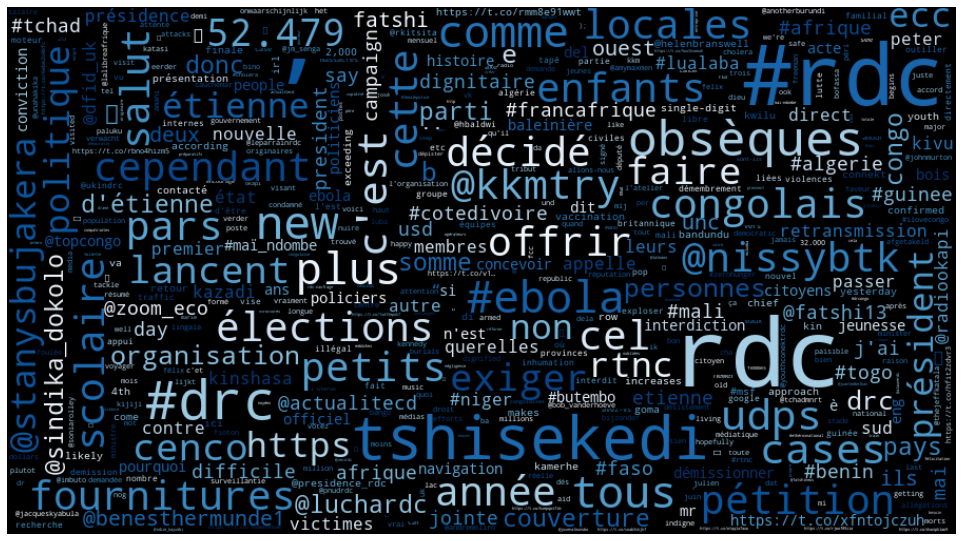

In [20]:
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let us try to create a color map with DRC flag to make the wordcount made with DRC colors to see what will happen.

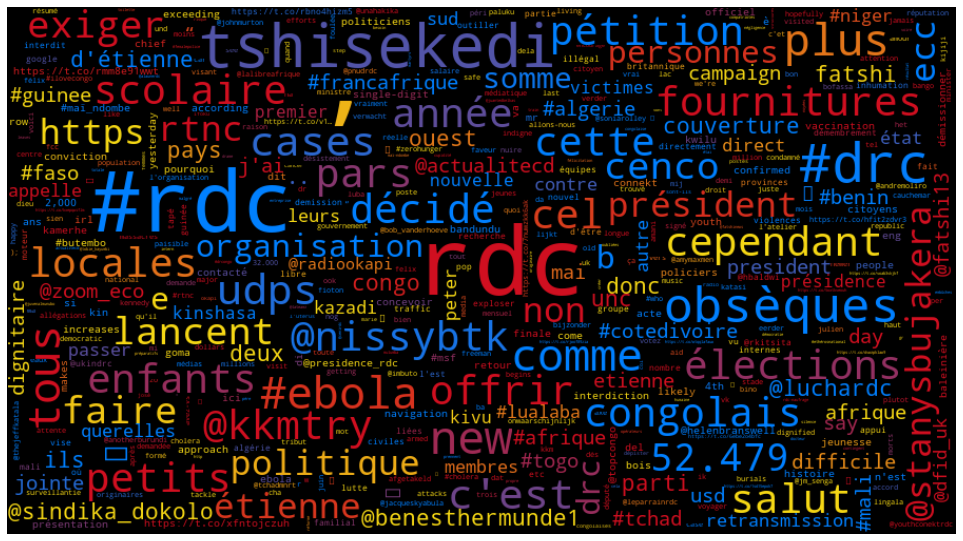

In [21]:
drc_flag_color_map = colors.LinearSegmentedColormap.from_list("", ["#0080FF", 
                                                                   "#0080FF", 
                                                                   "#D00F20",
                                                                   "#D00F20",
                                                                   "#F5D715",
                                                                   "#F5D715"])
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap=drc_flag_color_map,normalize_plurals=True).generate_from_frequencies(term_counts)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### V. Improvement ton twitter preprocessing 

In [82]:
!pip install unidecode

     |████████████████████████████████| 245kB 366kB/s eta 0:00:01


In [115]:
import re
import preprocessor as tweet_preprocessor
import unidecode
import many_stop_words

As you can see from the wordcount we find meaningless words, ie (c'est, different word counts for a word with hashtag and without hashtag, twitter handles(Idon't know yet if I should remove them or not))
We can use the approachs form [this blogpost](https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf) to refractor our cleaning process.
- the first approach was to use a thrid part libary to clean the tweet. all the cleaning process are done in background with that libray. The library is called : *[tweet-preprocessor](https://pypi.org/project/tweet-preprocessor/)*
- the second approach was to use additional steps after the normal prepocessin we didd, those steps are (emoji removals, replacing consecutives ascii char with spaces)f
- another prepocessing approach to do is to consider the fact that we are dealing with french tweets, we need to do some prepocessing due to the complexity of that language.
- I will also remove the # from the hashtags

In [84]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
emoticons = emoticons_happy.union(emoticons_sad)
# let append emoticons to words_to remove

words_to_remove.append(emoticons)

In [85]:
len(words_to_remove)

376

let remove also the emojis

In [86]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [99]:
def remove_emoji(text):
    """
    remove the emojis and non ascii char with space from the tweet
    """
    #after tweepy preprocessing the colon symbol left remain after      #removing mentions
    text = re.sub(r':', '', text)
    text = re.sub(r'‚Ä¶', '', text)
    #replace consecutive non-ASCII characters with a space
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    #remove emojis from tweet
    text = emoji_pattern.sub(r'', text)
    return text

Here is the final normalization process:
- remove_using_library
- remove_emoji()
- process_text()
- french_additional_step()

Let do it 

In [100]:
# I decide to keep mentions and hashtags
tweet_preprocessor.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.RESERVED, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.NUMBER)

- let apply french additionnal step by removing the stops word we have , we will use an addional library
add additional french word in list of word to remove

In [116]:
words_to_remove.append(many_stop_words.get_stop_words('FR'))
words_to_remove = set(words_to_remove)

In [117]:
def get_term_count(path):
    """
    preporcess and return terms count from a file of tweets.
    Parm :
    path:  string : the path of the tweet files
    return a dictionary of term and the count of they occurences
    """
    term_counts = Counter()
    for tweet in read_tweets_file(path):
        text = tweet_preprocessor.clean(tweet.get('text'))
        #convert string with accent to string without accenst
        text = unidecode.unidecode(text)
        # remove the '#' before a hashtag
        text = text.replace('#', '')
        text = remove_emoji(text)
        tokens = process_text(text=text, tokenizer=tweet_tokenizer, words_to_remove=words_to_remove)
        term_counts.update(tokens)
    return term_counts

In [119]:
for tag, count in get_term_count('../data/stream_DRC_RDC_DRCongo_RDCongo.jsonl').most_common(5):
    print("{}: {}".format(tag, count))

rdc: 99
drc: 21
tshisekedi: 19
ebola: 13
j'ai: 12


#### Ploting the wordcount graph again.

In [124]:
drc_flag_color_map = colors.LinearSegmentedColormap.from_list("", ["#0080FF", 
                                                                   "#0080FF", 
                                                                   "#D00F20",
                                                                   "#D00F20",
                                                                   "#F5D715",
                                                                   "#F5D715"])
def generate_word_cloud(term_counts, color_map):
    return WordCloud(width=900,
                     height=500,
                     max_words=500,
                     max_font_size=100,
                     relative_scaling=0.5,
                     colormap=color_map,
                     normalize_plurals=True).generate_from_frequencies(term_counts)
def plot_word_cloud(word_cloud):
    plt.figure(figsize=(17,14))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

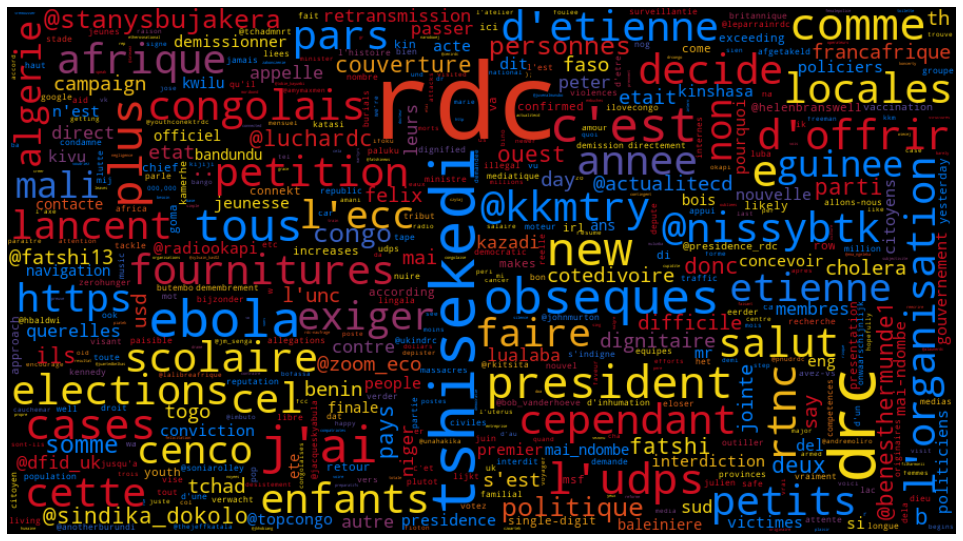

In [125]:
term_counts = get_term_count('../data/stream_DRC_RDC_DRCongo_RDCongo.jsonl')
word_cloud = generate_word_cloud(term_counts, drc_flag_color_map)
plot_word_cloud(word_cloud)